In [123]:
import pandas as pd   
import numpy as np    
import matplotlib.pyplot as plt 
import seaborn as sns

import time
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold


from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")
%config InlineBackend.figure_formats = ['retina']

In [103]:
people = pd.read_csv('../raw_data/people_analytics.csv')

In [104]:
people_train, people_test = train_test_split(people, random_state = 0)

In [105]:
people_train['EduField_Dept'] = 0
for i, row in people_train.iterrows():
    if row['EducationField']=='Human Resources' and row['Department']=='Human Resources':
        people_train['EduField_Dept'][i] = 1
    elif row['EducationField']=='Life Sciences' and row['Department']=='Sales':
        people_train['EduField_Dept'][i] = 2
    elif row['EducationField']=='Life Sciences' and row['Department']=='Research & Development':
        people_train['EduField_Dept'][i] = 1
    elif row['EducationField']=='Medical' and row['Department']=='Sales':
        people_train['EduField_Dept'][i] = 2
    elif row['EducationField']=='Medical' and row['Department']=='Research & Development':
        people_train['EduField_Dept'][i] = 1
    elif row['EducationField']=='Technical Degree' and row['Department']=='Sales':
        people_train['EduField_Dept'][i] = 2
    elif row['EducationField']=='Technical Degree' and row['Department']=='Research & Development':
        people_train['EduField_Dept'][i] = 1
    elif row['EducationField']=='Marketing' and row['Department']=='Sales':
        people_train['EduField_Dept'][i] = 1

In [106]:
people_train['Job_Coy'] = people_train['JobLevel'] / (people_train['YearsAtCompany'] + 1)

people_train['Edu_Age_TotalWorking'] = people_train['Education'] / \
                                            (people_train['Age'] + people_train['TotalWorkingYears'])

people_train['CurrMgr_Coy'] = people_train['YearsWithCurrManager'] / (people_train['YearsAtCompany'] + 1)

people_train['CurrRole_CurrMgr'] = people_train['YearsInCurrentRole'] / \
                                            (people_train['YearsWithCurrManager'] + 1)

In [107]:
# Dropping unimportant columns
people_train = people_train.drop(columns = ['Over18', 'EmployeeCount', 'EmployeeNumber', 'StandardHours'])

In [108]:
categorical_data = {
    'Attrition': {'No':0, 
                  'Yes':1}, 
    
    'BusinessTravel': {'Non-Travel':0, 
                       'Travel_Frequently':1, 
                       'Travel_Rarely':2}, 
    
    'Department': {'Human Resources':0, 
                   'Research & Development':1, 
                   'Sales':2}, 
    
    'EducationField': {'Human Resources':0, 
                       'Life Sciences':1, 
                       'Marketing':2, 'Medical':3, 
                       'Technical Degree':4, 
                       'Other':5}, 
    
    'Gender': {'Female':0, 
               'Male':0}, 
    
    'JobRole': {'Healthcare Representative':0, 
                'Human Resources':1, 
                'Laboratory Technician':2, 
                'Manager':3, 
                'Manufacturing Director':4, 
                'Research Director':5, 
                'Research Scientist':6, 
                'Sales Executive':7, 
                'Sales Representative':8}, 
    'MaritalStatus': {'Divorced':0, 
                      'Single':1, 
                      'Married':2},
    
    'OverTime': {'No':0, 
                 'Yes':1}
}

# Replacing values with categorical_data map
people_train = people_train.replace(categorical_data)

In [109]:
X = people_train.drop('Attrition', axis = 1)
y = people_train['Attrition']

## RandomForest Classifier

In [110]:
# RandomForestClassifier to look for important key features
rfc = RandomForestClassifier(random_state = 0, n_estimators = 200, max_depth = 3)
rfc_model = rfc.fit(X, y)

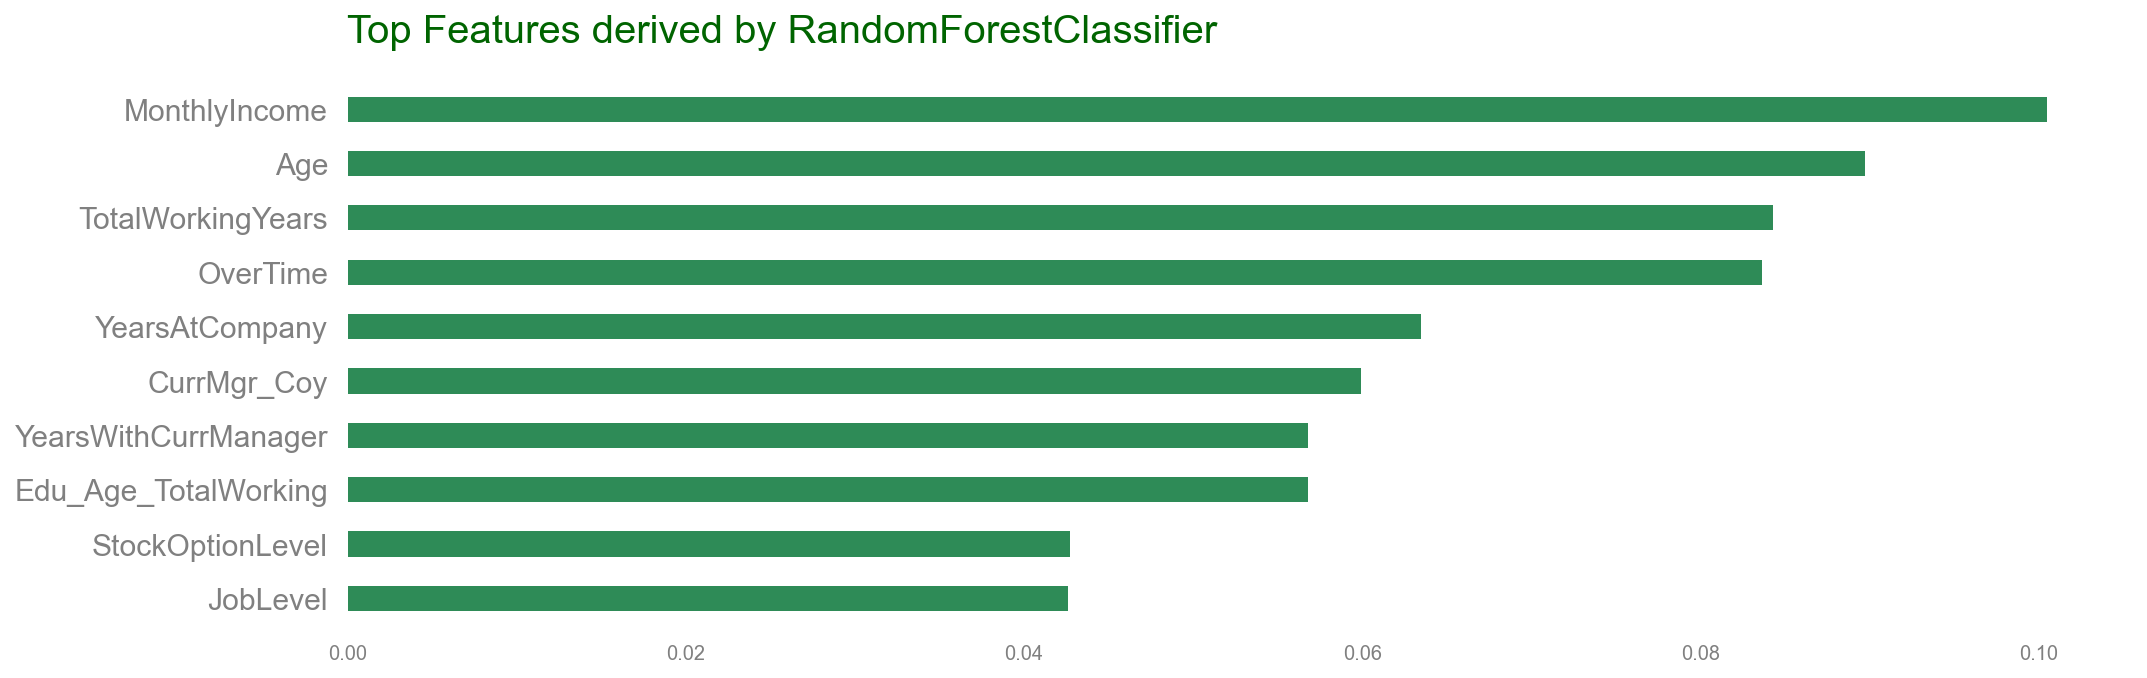

In [111]:
# Checking feature importance 
n = 10    # specify n (top n features)
fig, ax = plt.subplots(1, 1, figsize = (16, 5))

pd.Series(rfc_model.feature_importances_, 
          index = X.columns).nlargest(n).plot(kind='barh', color = 'seagreen').invert_yaxis()

plt.yticks(size=15, color='gray')
plt.xticks(size=10, color='gray')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.title('Top Features derived by RandomForestClassifier', size=20, color = 'darkgreen', pad = 20, loc = 'left');

In [112]:
# check for correlation between top 10 features
top10_features = pd.Series(rfc_model.feature_importances_, index = X.columns).nlargest(10)

X_top10 = people_train.loc[:, top10_features.index]
y_top10 = people_train['Attrition']
people_top10 = X_top10.join(y_top10)

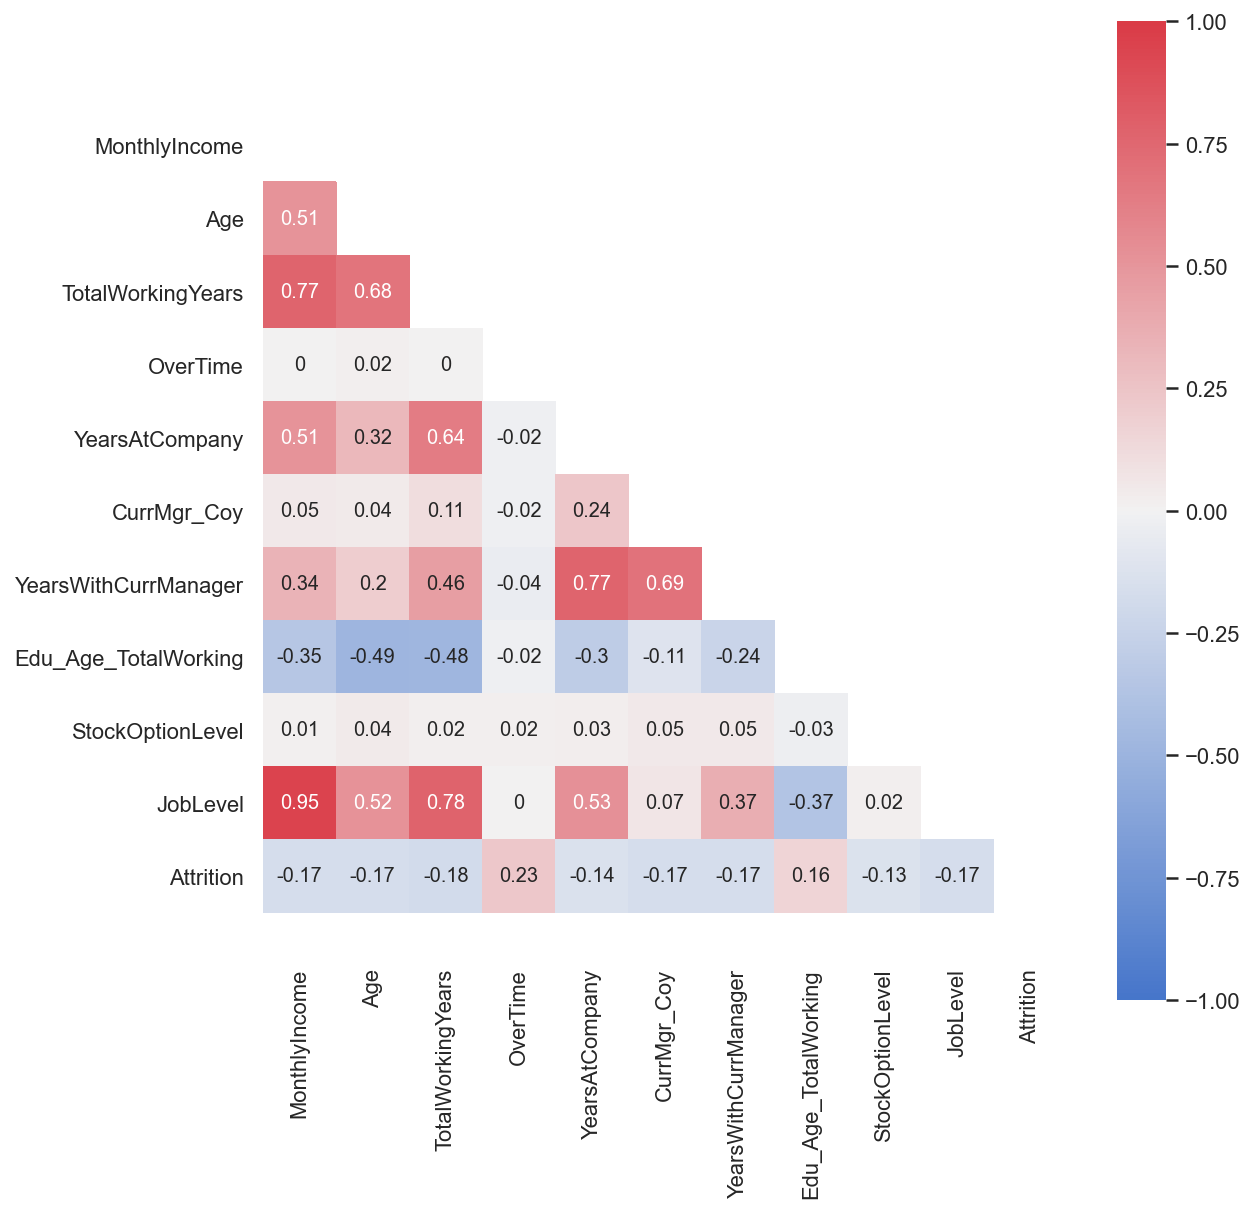

In [113]:
# Correlation matrix heatmap visualization

# Setting plot style
sns.set(style="white")

# Creating a mask for the upper triangle
mask = np.zeros_like(people_top10.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure to control size of heatmap
fig, ax = plt.subplots(figsize=(9,9))

# Create a custom color palette
cmap = sns.diverging_palette(255, 10, as_cmap = True)  # as_cmap returns a matplotlib colormap object rather than a list of colors
# Red=10, Green=128, Blue=255

# Plot the heatmap
sns.heatmap(people_top10.corr().round(2), 
            mask = mask, annot = True, 
            annot_kws = {"size": 10}, square = True, 
            cmap = cmap, vmin = -1, vmax = 1, ax = ax)  

# Prevent Heatmap Cut-Off Issue
bottom, top = ax.get_ylim()
ax.set_ylim(bottom+0.5, top-0.5);

In [114]:
# drop highly correlated features: JobLevel & MonthlyIncome = 0.95 (JobLevel has lower feature importance)
people_train = people_train.drop(columns = ['JobLevel'])

In [115]:
# re-run correlation matrix heatmap: TotalWorkingYears & MonthlyIncome = 0.77, YearsWithCurrManager & YearsAtCompany = 0.77
people_train = people_train.drop(columns = ['TotalWorkingYears', 'YearsWithCurrManager'])

In [116]:
# re-run correlation matrix heatmap: YearsInCurrentRole & YearsAtCompany = 0.76
people_train = people_train.drop(columns = ['YearsInCurrentRole'])

In [117]:
# re-run correlation matrix heatmap: YearsAtCompany & MonthlyIncome = 0.51
people_train = people_train.drop(columns = ['YearsAtCompany'])

In [118]:
# re-run correlation matrix heatmap: Age & MonthlyIncome = 0.5
people_train = people_train.drop(columns = ['Age'])

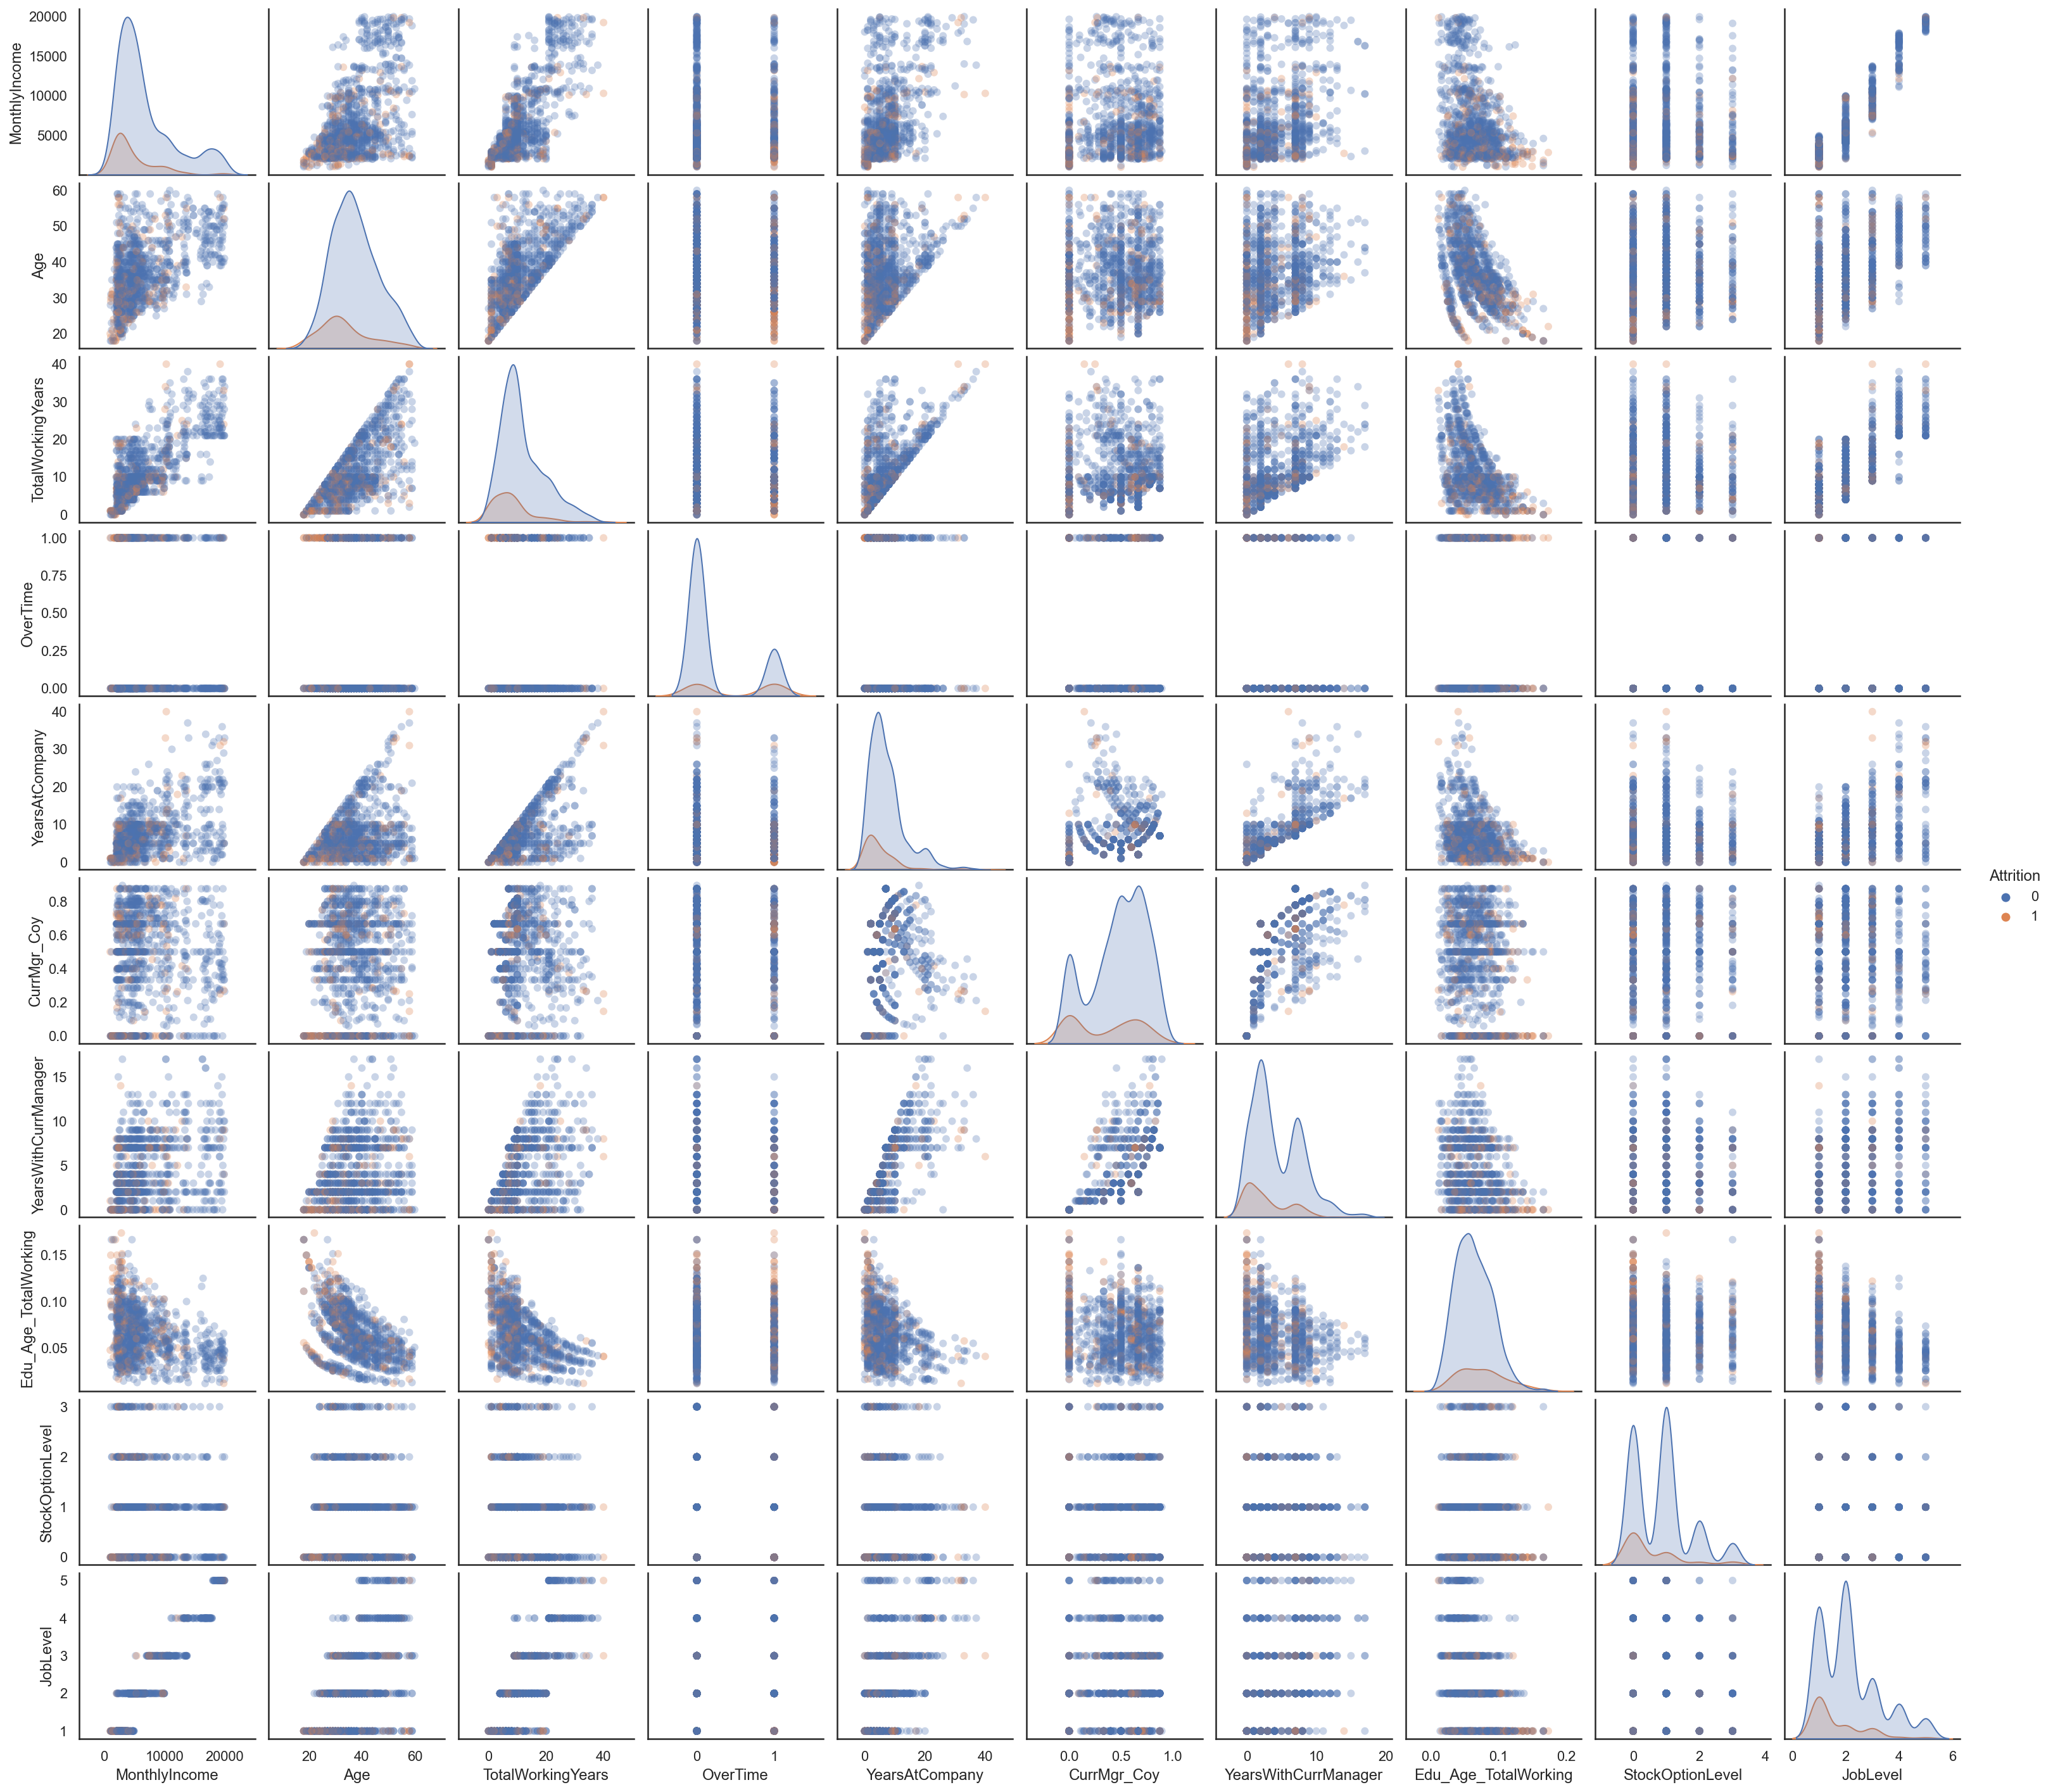

In [120]:
# to visualise pair plot of top 10 features
sns.pairplot(people_top10, hue = 'Attrition', 
             plot_kws = dict(alpha=.3, edgecolor='none'), 
             height = 2, aspect = 1.1);

In [125]:
X = people_train.drop('Attrition', axis=1)
y = people_train['Attrition']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 0, stratify = y)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state = 0) 